# Yoga Class Analysis using Human Pose Estimation

<div style="text-align: center;">
    <a href="https://colab.research.google.com/github/SkanderGasmi/Yoga/blob/main/main.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</div>


## 1. Buisness understanding
The goal of this project is to automatically classify images of people doing yoga poses into different categories using image recognition algorithms, such as convolutional neural network (CNN). This is an image recognition problem that belongs to the field of machine learning.


## 2. Data Requirements & Data Collection
The dataset used for this project is a collection of images of people doing yoga poses, divided into train and test sets. The train set is used to train the model, while the test set is used to evaluate the performance of the model.


In [2]:
import requests
import os
import zipfile
import gdown

def google_drive_share_link_to_direct_download_link(link):
    file_id = link.split('/')[-2]
    return f"https://drive.google.com/uc?id={file_id}&export=download"

# Google Drive sharing link
google_drive_sharing_link = "https://drive.google.com/file/d/1a2CUyPy3jB2AGG5nH-nWyXWuAc-hWuFv/view?usp=share_link"

# Convert the sharing link to a direct download link
google_drive_direct_download_link = google_drive_share_link_to_direct_download_link(google_drive_sharing_link)

# Create data directory if it doesn't exist
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the dataset if it doesn't exist
zip_file_path = os.path.join(data_dir, "yoga_dataset.zip")

if not os.path.exists(zip_file_path):
    print("Downloading dataset...")
    gdown.download(google_drive_direct_download_link, zip_file_path, quiet=False)
else:
    print("Dataset already downloaded.")

# Check the downloaded file size
file_size = os.path.getsize(zip_file_path)
# Format file size in the most appropriate unit
if file_size < 1024:
    size_str = f"{file_size} bytes"
elif file_size < 1024**2:
    size_str = f"{file_size/1024:.1f} KB"
elif file_size < 1024**3:
    size_str = f"{file_size/1024**2:.1f} MB"
else:
    size_str = f"{file_size/1024**3:.1f} GB"
    
print(f"Downloaded file size: {size_str}")

# Create extracted and backup directories if they don't exist
extracted_data_path = os.path.join(data_dir, "extracted")
backup_data_path = os.path.join(data_dir, "backup")

def extract_to_folder(zip_file_path, target_folder):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        for member in zip_ref.infolist():
            if member.filename.startswith("yoga_dataset/"):
                target_path = os.path.join(target_folder, member.filename[len("yoga_dataset/"):])
                if member.is_dir():
                    os.makedirs(target_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with open(target_path, "wb") as target_file:
                        target_file.write(zip_ref.read(member))

if not os.path.exists(extracted_data_path):
    os.makedirs(extracted_data_path)
    print("Extracting dataset...")
    extract_to_folder(zip_file_path, extracted_data_path)
else:
    print("Dataset already extracted.")

if not os.path.exists(backup_data_path):
    os.makedirs(backup_data_path)
    print("Extracting dataset to backup folder...")
    extract_to_folder(zip_file_path, backup_data_path)
else:
    print("Dataset already extracted to backup folder.")


Dataset already downloaded.
Downloaded file size: 286.9 MB
Dataset already extracted.
Dataset already extracted to backup folder.


## 3.Data Understanding & Data Preparation
### 3.1 Data Understanding



Total corrupted files found: 0
Total corrupted files found: 0


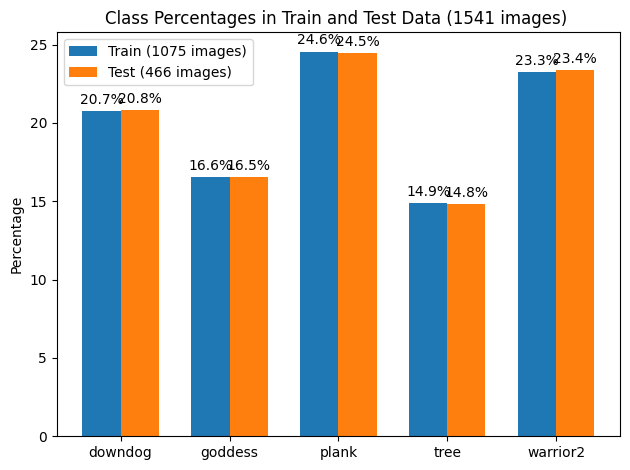

In [3]:
import os
import zipfile
import gdown
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


# Define the main data directories
data_folders = {
    "train": os.path.join(extracted_data_path, "train"),
    "test": os.path.join(extracted_data_path, "test")
}

#There are a few corrupted files so we will proceed by removing them

from PIL import Image
import os
import stat

def set_permissions(path):
    os.chmod(path, stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP | stat.S_IROTH | stat.S_IXOTH)

def check_images(image_dir):
    set_permissions(image_dir)
    corrupted_files_count = 0
    for root, dirs, files in os.walk(image_dir):
        for d in dirs:
            set_permissions(os.path.join(root, d))
        for filename in files:
            filepath = os.path.join(root, filename)
            try:
                with Image.open(filepath) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                corrupted_files_count += 1
                print(f"Removing {filepath}: {e}")
                try:
                    os.remove(filepath)
                except PermissionError as pe:
                    print(f"Permission denied: {pe}")
    print(f"Total corrupted files found: {corrupted_files_count}")


check_images(data_folders["train"])
check_images(data_folders["test"])



# Initialize dictionaries to store class counts
class_counts_train = {}
class_counts_test = {}

# Loop through the train and test folders
for data_type, data_folder in data_folders.items():

    # Get the list of label folders
    label_folders = os.listdir(data_folder)
    
    for label_folder in label_folders:
        label_folder_path = os.path.join(data_folder, label_folder)
        
        # Get the list of images in the label folder
        image_files = os.listdir(label_folder_path)
        
        # Store class counts for train and test data
        if data_type == "train":
            class_counts_train[label_folder] = len(image_files)
        else:
            class_counts_test[label_folder] = len(image_files)

# Calculate total number of images in train and test data
total_train = sum(class_counts_train.values())
total_test = sum(class_counts_test.values())

# Calculate class percentages
class_percentages_train = {k: v / total_train * 100 for k, v in class_counts_train.items()}
class_percentages_test = {k: v / total_test * 100 for k, v in class_counts_test.items()}

# Create bar plots to compare class percentages
labels = class_counts_train.keys()
train_percentages = class_percentages_train.values()
test_percentages = class_percentages_test.values()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, train_percentages, width, label=f'Train ({total_train} images)')
rects2 = ax.bar(x + width / 2, test_percentages, width, label=f'Test ({total_test} images)')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title(f'Class Percentages in Train and Test Data ({total_train + total_test} images) ')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a label above each bar in *rects*, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


The dataset used for this project is a collection of images of people doing yoga poses, divided into train(1075 images) and test(466 images) sets. The dataset contains a total of 1541 images, with 5 different categories of yoga poses. 


From the figure, we can see that the dataset is relatively balanced, with each category containing a similar number of images.


(2 / 2

From the output of the previous cell, we can conclude that the dataset is relatively balanced as the percentages of each class are almost the same between the train and test sets. There are no major data cleaning issues at this stage. However, we might encounter class imbalance later when we train our model, and we need to take that into account.

In the next cell, we will visualize some sample images from the dataset to get an idea of what the images look like and how they are distributed across classes.


The bar plot above shows the class percentages in the train and test data for the yoga pose classification task. The data is split into five categories: downdog, goddess, plank, tree, and warrior2.

In the train data, the most common pose is plank, accounting for 24.6% of the images, followed closely by warrior2 at 23.3%. The least common pose is tree, accounting for only 14.9% of the images.

The test data has similar percentages to the train data, with plank and warrior2 being the most common poses, accounting for 24.5% and 23.4% of the images, respectively. The least common pose is also tree, accounting for only 14.8% of the images.

Overall, the class percentages in the train and test data appear to be relatively balanced, with no one pose being significantly over- or under-represented. This suggests that the data is well-suited for training and testing a classification model.)

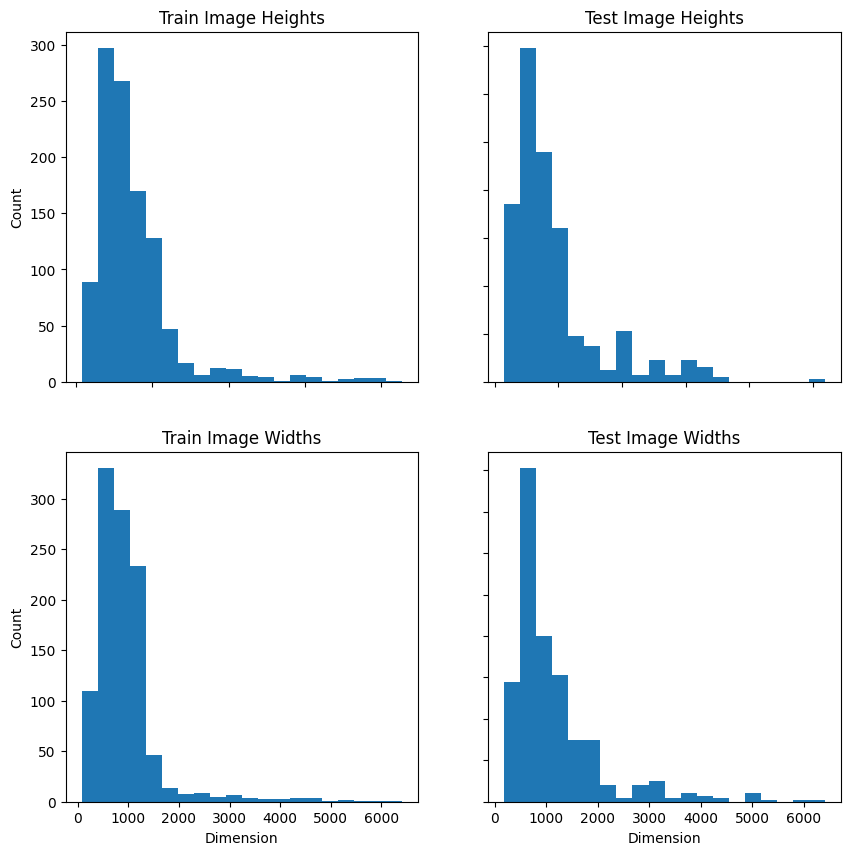

In [3]:
import os
import zipfile
import gdown
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Initialize lists to store image dimensions
train_dims = []
test_dims = []

# Loop through the train and test folders
for data_type, data_folder in data_folders.items():

    # Get the list of label folders
    label_folders = os.listdir(data_folder)

    for label_folder in label_folders:
        label_folder_path = os.path.join(data_folder, label_folder)
        
        # Get the list of images in the label folder
        image_files = os.listdir(label_folder_path)
        
        # Get the dimensions of each image and store in list
        for image_file in image_files:
            image_path = os.path.join(label_folder_path, image_file)
            image = cv2.imread(image_path)
            height, width, channels = image.shape
            
            if data_type == "train":
                train_dims.append((height, width))
            else:
                test_dims.append((height, width))
                
# Convert dimensions to numpy arrays
train_dims = np.array(train_dims)
test_dims = np.array(test_dims)

# Create histograms of image heights and widths
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(train_dims[:, 0], bins=20)
axs[0, 0].set_title('Train Image Heights')
axs[0, 1].hist(test_dims[:, 0], bins=20)
axs[0, 1].set_title('Test Image Heights')
axs[1, 0].hist(train_dims[:, 1], bins=20)
axs[1, 0].set_title('Train Image Widths')
axs[1, 1].hist(test_dims[:, 1], bins=20)
axs[1, 1].set_title('Test Image Widths')

for ax in axs.flat:
    ax.set(xlabel='Dimension', ylabel='Count')

# Hide x labels and tick labels for top plots and y ticks for right plots
for ax in axs.flat:
    ax.label_outer()

plt.show()



The images have different sizes, which can affect the performance of the model if not handled properly.
    

## 3.2 Data Preparation
In order to preprocess the dataset, we have applied several techniques to handle the varying sizes of the images. Firstly, all the images have been resized to a fixed size which will be determined by a grid search. This is necessary to ensure that all images have the same dimensions, which is a prerequisite for training a CNN model.

We have also divided the training data into training and validation sets using an 80:20 ratio. This will allow us to train the model on a larger dataset and evaluate its performance on unseen data.

In addition to resizing the images, we have also employed data augmentation techniques to increase the size and diversity of the dataset. These techniques include rotation, scaling, and flipping, which can help the model generalize better to new data. We used the Tensorflow ImageGenerator API to perform these augmentations. Furthermore, we have normalized the pixel values of the images to a range of [0,1]. This helps to prevent numerical instability and improves the convergence of the model during training.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt

# Set the input size, batch size, and number of epochs
input_size = (500, 500)
batch_size = 32
epochs = 50

train_dir = data_folders["train"]
test_dir = data_folders["test"]

import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class RobustImageDataGenerator(ImageDataGenerator):
    def _get_batches_of_transformed_samples(self, index_array):
        images = []
        labels = []
        for i in index_array:
            try:
                x, y = super()._get_batches_of_transformed_samples(np.array([i]))
                images.append(x[0])
                labels.append(y[0])
            except Exception as e:
                print(f"Skipping image {i} due to error: {e}")
                continue

        return np.array(images), np.array(labels)

# Use the new RobustImageDataGenerator instead of ImageDataGenerator
train_datagen = RobustImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)


test_datagen = RobustImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

class_names = list(train_generator.class_indices.keys())

# Model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_size + (3,)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}")


Found 862 images belonging to 5 classes.
Found 213 images belonging to 5 classes.
Found 466 images belonging to 5 classes.
Epoch 1/50
13/27 [=============>................] - ETA: 2:06 - loss: 16.0567 - accuracy: 0.2198

c:\Users\skand\Desktop\yoga\venv\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


27/27 [==============================] - 297s 11s/step - loss: 8.5495 - accuracy: 0.2436 - val_loss: 1.5767 - val_accuracy: 0.3474
Epoch 2/50
27/27 [==============================] - 266s 10s/step - loss: 1.5199 - accuracy: 0.3944 - val_loss: 1.4480 - val_accuracy: 0.5305
Epoch 3/50
 7/27 [======>.......................] - ETA: 1:45 - loss: 1.3927 - accuracy: 0.4107

KeyboardInterrupt: 

In [ ]:
%pip install hyperopt


AttributeError: module 'numpy' has no attribute 'round'